# Box Office Revenue Predictive Models

### Exploratory Data Analysis Notebook

The purpose of this project is to further practice building my own models in order to build and evaluate the performance of models that predict the revenue of movies, as a function of features associated with them.

These models will be evaluated against relevant KPI's (R-squared, Mean Absolute Error, MAE^2), and the best model will be used to predict revenue performance for movies in a world where theaters continued to stay open in 2020 and 2021.

The purpose of this notebook is to begin to examine the relationships between different features of the data set and my target feature: revenue.  At this point I have two main relationships in mind that I'd like to look at: 

**1 - Revenue trends relative to other numeric features (budget, Tagline_length, Overview_length, etc.)** The first thing that I want to do is create a correlation plot and see what stands out. 

**2- Trends or grouping of revenue by categorical feature.**  My initial plan is to examine categorical features in certain groups using histogram and violin plots.   I think the best method will likely be to get dummy variables for each categorical feature.  I'd like to examine each in relation to revenue independently before examining the entire dataset with dummy variables.  The first step here is to create dummy variables with pd.get_dummies().  I'm going to store these as individual dataframes as well as concatenating them into a single larger dataframe that I'll later use PCA on.


I want to recognize that this is my first instance of conducting exploratory data analysis on significantly categorical data and prior to diving into the process I chose to read through this EDA notebook on Kaggle examining categorical data: https://www.kaggle.com/nextbigwhat/eda-for-categorical-variables-a-beginner-s-way

In [60]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import ast
import warnings
from datetime import date 
warnings.filterwarnings('ignore')  

# sets the plotsize for the whole notebook to a specific size (since plt.plot takes no figsize argument)
# I discovered this setting from Bartoz Mikulski's blog: 
# https://www.mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook/

plt.rcParams["figure.figsize"] = (8,8)   

In [61]:
boxoffice = pd.read_csv(r'C:\Users\deann\Documents\Data\Box Office Prediction Data\boxoffice_cleaned.csv')

In [62]:
boxoffice.columns

Index(['belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'tagline', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'Overview_length', 'Tag_length', 'collectionbool'],
      dtype='object')

In [63]:
boxoffice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  761 non-null    object 
 1   budget                 2333 non-null   int64  
 2   genres                 2332 non-null   object 
 3   imdb_id                2333 non-null   int64  
 4   original_language      2333 non-null   object 
 5   original_title         2333 non-null   object 
 6   overview               2332 non-null   object 
 7   popularity             2333 non-null   float64
 8   production_companies   2316 non-null   object 
 9   production_countries   2328 non-null   object 
 10  release_date           2333 non-null   object 
 11  runtime                2333 non-null   float64
 12  spoken_languages       2328 non-null   object 
 13  tagline                2127 non-null   object 
 14  title                  2333 non-null   object 
 15  Keyw

My first inclination is to create a separate dataframe for both categorical and numeric data right away. 

I already know that I'll need to create a lot of dummy variables for categorical features, which will get very complicated very quickly given the number of potential unique values in features like cast and Keywords.  I'll also need to consider annual trends using the release_date feature. 

In [64]:
boxofc_cat = boxoffice.select_dtypes(include=['object', 'bool'])
boxofc_cat.head(3)

,belongs_to_collection,genres,original_language,original_title,overview,production_companies,production_countries,release_date,spoken_languages,tagline,title,Keywords,cast,crew,collectionbool
0,The Princess Diaries Collection,"['Comedy', 'Drama', 'Family', 'Romance']",en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,['Walt Disney Pictures'],['United States of America'],8/6/04,['English'],It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"['coronation', 'duty', 'marriage', 'falling in...","['Anne Hathaway', 'Julie Andrews', 'H√©ctor El...","['Garry Marshall', 'Charles Minsky', 'John Deb...",True
1,NaN,['Drama'],en,Whiplash,"Under the direction of a ruthless instructor, ...","['Bold Films', 'Blumhouse Productions', 'Right...",['United States of America'],10/10/14,['English'],The road to greatness can take you to the edge.,Whiplash,"['jazz', 'obsession', 'conservatory', 'music t...","['Miles Teller', 'J.K. Simmons', 'Melissa Beno...","['Terri Taylor', 'Richard Henderson', 'Jeffrey...",False
2,NaN,"['Animation', 'Adventure', 'Family']",en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",NaN,NaN,8/6/87,['English'],NaN,Pinocchio and the Emperor of the Night,NaN,"['Scott Grimes', 'Tom Bosley', 'Rickie Lee Jon...","['Collodi', 'Hal Sutherland', ""Dennis O'Flaher...",False


In [65]:
boxofc_num = boxoffice.select_dtypes(include=['float64', 'int64'])
boxofc_num.head()

,budget,imdb_id,popularity,runtime,revenue,Overview_length,Tag_length
0,40000000,368933,8.25,113.00,"134,734,481.00",393.00,60.00
1,3300000,2582802,64.30,105.00,"48,982,041.00",130.00,47.00
2,8000000,93743,0.74,83.00,"3,418,605.00",150.00,nan
3,14000000,431021,7.29,92.00,"85,446,075.00",208.00,36.00
4,0,117110,6.90,100.00,"4,259,710.00",397.00,27.00


# Numerical Data

Numerical data is going to be the simplest set of data to explore and I've decided that I'll start here, then address the categorical data and create dummy variables.  

My process for this is going to be looking at basic summary statistics for my numerical dataframe, then examining several hypotheses I have regarding how numerical film features relate to my target variable - revenue. 

In [66]:
pd.options.display.float_format = '{:,.2f}'.format  #removes scientific notation and adds comma separators for floats

boxofc_num.describe()

,budget,imdb_id,popularity,runtime,revenue,Overview_length,Tag_length
count,"2,333.00","2,333.00","2,333.00","2,333.00","2,333.00","2,332.00","2,127.00"
mean,"44,258,850.66","878,951.72",12.56,111.30,"147,844,739.08",306.17,40.81
std,"46,336,104.75","1,058,248.49",19.09,20.72,"176,731,176.79",151.12,22.77
min,0.00,"4,972.00",0.00,0.00,"5,806.00",41.00,3.00
25%,"11,000,000.00","118,747.00",7.49,97.00,"40,766,041.00",187.00,25.00
50%,"30,000,000.00","372,784.00",10.22,108.00,"96,889,998.00",291.00,36.00
75%,"60,000,000.00","1,402,488.00",13.39,122.00,"179,379,533.00",388.25,50.50
max,"380,000,000.00","6,044,910.00",547.49,248.00,"1,516,045,911.00","1,000.00",213.00


The first thing I notice when examining these features is that both budget and runtime have values that are equal to zero; something that's not possible for a film that was released globally.  I'll need to examine both of these situations prior to testing hypotheses around either feature.   If there are a large number of 'zero' values in either column I'll then need to decide if I'm going to imput the mean or median for either. 

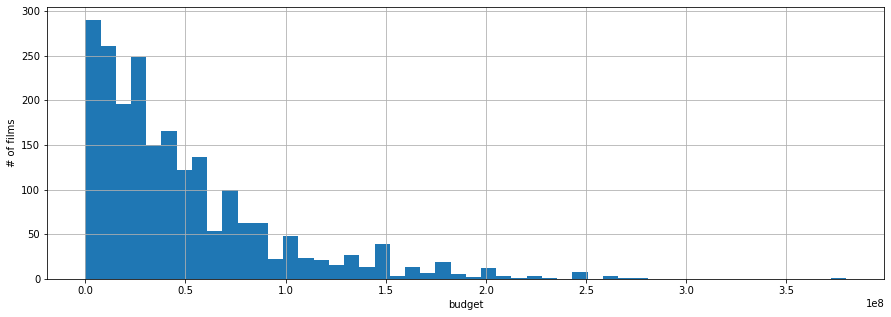

In [67]:
# view distribution of films whose budget is not equal to zero to determine if I'll fill with the mean or median

boxofc_num.budget[boxofc_num.budget != 0].hist(bins=50, figsize = (15, 5)) 
plt.xlabel('budget')
plt.ylabel('# of films');

In [68]:
# count films whose budget is equal to 0

null_budget = boxofc_num[boxofc_num.budget == 0].count()

print(null_budget)

budget             194
imdb_id            194
popularity         194
runtime            194
revenue            194
Overview_length    194
Tag_length         127
dtype: int64


In [69]:
# determining if mean or median budget is best to imput into this column

budget_mean = round(np.mean(boxofc_num.budget[boxofc_num.budget != 0]), 2)

budget_median = np.median(boxofc_num.budget[boxofc_num.budget != 0])

print('The mean film budget is: ', budget_mean)
print('The median film budget is: ', budget_median)

The mean film budget is:  48272977.37
The median film budget is:  35000000.0


Both the mean and median for budget are quite close to one another relative to this histogram since it's highly skewed to the right.  Given that it's best practice I'll impute the median for budget here. 

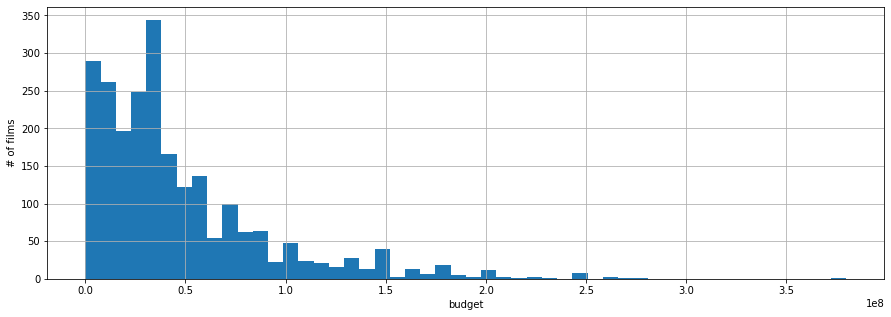

In [70]:
# impute the median into the numerical data frame

boxofc_num.loc[boxofc_num.budget == 0, 'budget'] = budget_median  

# plotting the new budget distribution

boxofc_num.budget.hist(bins=50, figsize = (15, 5)) 
plt.xlabel('budget')
plt.ylabel('# of films');

As expected there is a jump in budget at the bin where the median film budget is after imputing that value, however this is better than having 0 as a value for budget for 194 films.   Now I need to replicate this for movie runtime. 

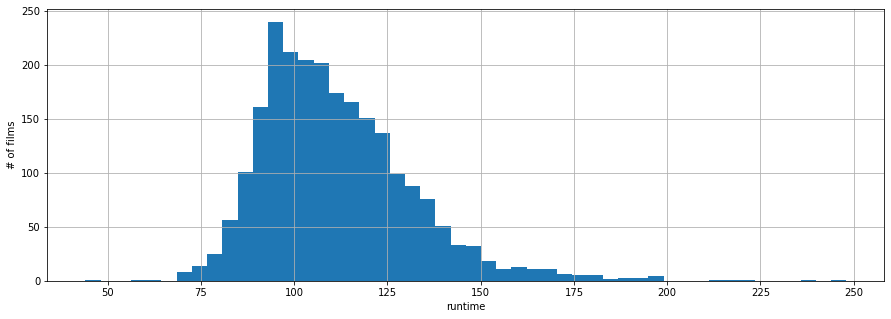

In [71]:
# view distribution of films whose runtime is not equal to zero 

boxofc_num.runtime[boxofc_num.runtime != 0].hist(bins=50, figsize = (15, 5)) 
plt.xlabel('runtime')
plt.ylabel('# of films');

This distribution has a normal distribution so it's likely that I'll impute the mean runtime.

In [72]:
# count films which have zero runtime

zero_runtime = boxofc_num[boxofc_num.runtime == 0].count()

print(zero_runtime)

budget             2
imdb_id            2
popularity         2
runtime            2
revenue            2
Overview_length    2
Tag_length         0
dtype: int64


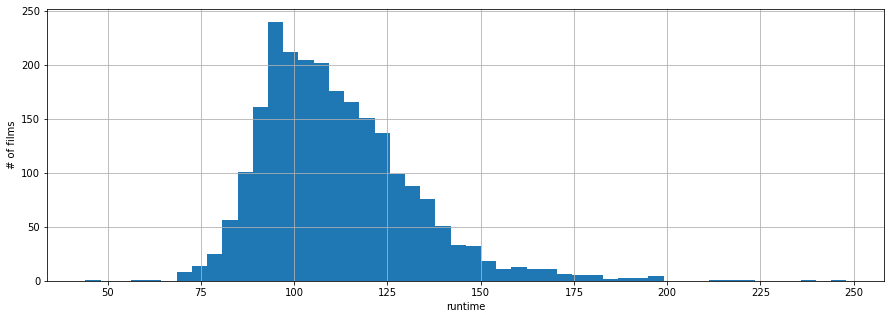

In [73]:
# with only two films that have no runtime listed I'm just going to impute the mean here given the normal distribution

mean_runtime = int(np.mean(boxofc_num.runtime[boxofc_num.runtime != 0]))

boxofc_num.runtime[boxofc_num.runtime == 0] = mean_runtime

#plot the new distribution

boxofc_num.runtime.hist(bins=50, figsize = (15, 5)) 
plt.xlabel('runtime')
plt.ylabel('# of films');

## Exploring Numerical features in relation to 'revenue'

I have several questions about how many of these numerical features relate back to the revenue of a film that I'd like to explore: 

1 - Does budget have a strong correlation to revenue?

2 - Do movies with longer runtime have more revenue?

3 - Does a higher value for popularity (a metric for user engagement with a film on TMDB's website) actually relate to revenue?

4 - Does a shorter tagline equate to higher revenue?

### Budget & Revenue

I hypothesize that budget has a high correlation with the revenue of a film, for two reasons.  The first is rather obvious, a high production value *should* indicate a film that is a high quality production.   Secondly, I suspect that studios will spend significantly more money marketing a film that has a larger budget as part of the 'sunk cost' fallacy.  While high production value films with lots of marketing efforts do flop at the box office, I intuit that these are the exceptions that make the rule.

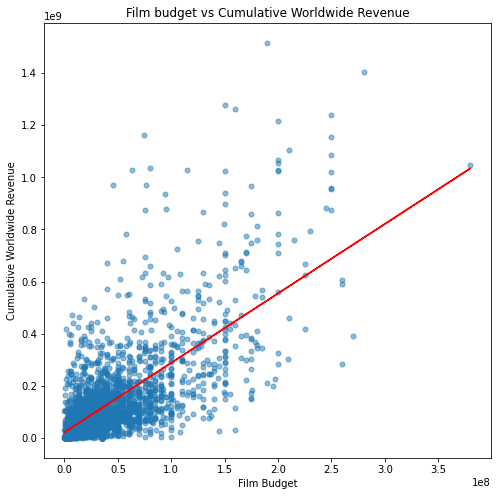

In [74]:
# plot budget vs revenue with line of best fit

plt.plot(boxofc_num['budget'], boxofc_num['revenue'], marker='.', linestyle='none', alpha=0.5, markersize=10)

# calculate slope & y-intercept

a, b = np.polyfit(boxofc_num['budget'], boxofc_num['revenue'], 1)

plt.plot(boxofc_num['budget'], (a*boxofc_num['budget'] + b), linestyle='-', c='r')

plt.title('Film budget vs Cumulative Worldwide Revenue')
plt.xlabel('Film Budget')
plt.ylabel('Cumulative Worldwide Revenue');

In [75]:
correlation = ['budget', 'revenue']

boxofc_num[correlation].corr()

,budget,revenue
budget,1.00,0.67
revenue,0.67,1.00


It seems that budget does have a fairly strong correlation with revenue, although it is somewhat difficult to tell based on the plot alone given the concentration of budget and revenue on the lower end.  I suspect that after training multiple models that it will become evident that there is diminishing returns on simply increasing a films budget to increase revenue.

One thing that **is** important to note is that the scale on the y-axis is from 0 - 1.5 billion, while the scale on the x-axis is from 0 - 400 million. Taking this into account it's clear that there is, generally speaking, roughly a 3x return on budget for films regardless of the size of budget.  Definitely a good business to be in!

### Runtime & Revenue

I have a hypothesis that a longer runtime will be correlated with a higher revenue (this is partially personal bias since films that are longer like Avengers: Endgame and Lord of the Rings are favourites of mine and also did fantastically well at the box office).  However I'm not sure that the correlation will be that strong given that runtime as a feature is normally distributed.

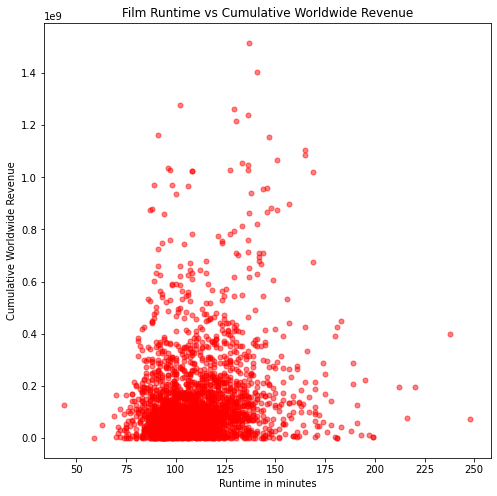

In [76]:
# plot runtime vs revenue

plt.plot(boxofc_num['runtime'], boxofc_num['revenue'], marker='.', linestyle='none', c='r', alpha=0.5, markersize = 10)

plt.title('Film Runtime vs Cumulative Worldwide Revenue')
plt.xlabel('Runtime in minutes')
plt.ylabel('Cumulative Worldwide Revenue');

In [77]:
correlation = ['runtime', 'revenue']

boxofc_num[correlation].corr()

,runtime,revenue
runtime,1.00,0.15
revenue,0.15,1.00


It doesn't seem that runtime is correlated much at all with revenue.  However runtime IS normally distributed and the relationship may not be linear - I'm curious to see what comes up in later analysis for this. 

### TMDB Popularity & Revenue

This dataset comes with a 'popularity' column which is a metric provided by The Movie Database (source of original data, and an IMDB alternative).  This metric is a score that TMDB provides in which a higher score indicates a higher degree of user interaction on their website. 

My hypothesis is that there will be a positive correlation between popoularity and revenue, but that the value of that correlation will be rather small. 

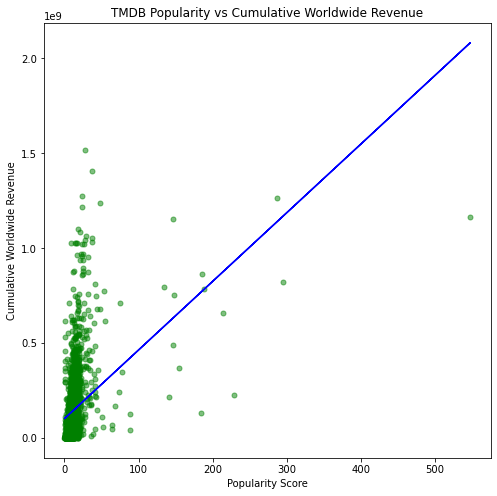

In [78]:
# plot popularity vs revenue with line of best fit

plt.plot(boxofc_num['popularity'], boxofc_num['revenue'], marker='.', linestyle='none', c='g', alpha=0.5, markersize = 10)

a, b = np.polyfit(boxofc_num['popularity'], boxofc_num['revenue'], 1)

plt.plot(boxofc_num['popularity'], a*boxofc_num['popularity']+b, linestyle='-', c='b')

plt.title('TMDB Popularity vs Cumulative Worldwide Revenue')
plt.xlabel('Popularity Score')
plt.ylabel('Cumulative Worldwide Revenue');

In [79]:
correlation = ['popularity', 'revenue']

boxofc_num[correlation].corr()

,popularity,revenue
popularity,1.00,0.39
revenue,0.39,1.00


While popularity is somewhat positively correlated with revenue, the effect seems to be relatively minimal given that most of the data has a popularity score that is less than 50. 

Further, I don't believe that this is something that would be useful for studio executives or other making decisions around whether or not a film would be a good investment since by definition popularity can only be measured *after* a film has been released.  Moving forward I think that it will be likely that this columnn gets dropped. 

### Tagline Length & Revenue



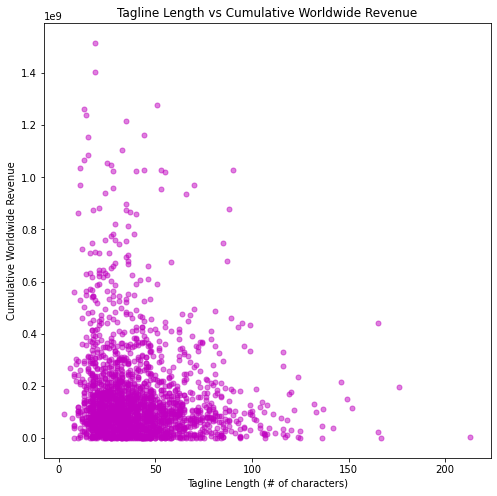

In [80]:
# plot Tagline Length vs revenue

plt.plot(boxofc_num['Tag_length'], boxofc_num['revenue'], marker='.', linestyle='none', c='m', alpha=0.5, markersize = 10)

plt.title('Tagline Length vs Cumulative Worldwide Revenue')
plt.xlabel('Tagline Length (# of characters)')
plt.ylabel('Cumulative Worldwide Revenue');

In [81]:
correlation = ['Tag_length', 'revenue']

boxofc_num[correlation].corr()

,Tag_length,revenue
Tag_length,1.00,-0.11
revenue,-0.11,1.00


Tagline length has a small negative correlation.  However what I find to be interesting is that no film with over 100 characters in it's tagline earned over 400,000,000 in revenue.  

This is useful information because most taglines will be written after a movie has been made and studios are beginning to market a film.  While this is notable, it's use is limited in that it meerely confirms what conventional wisdom is: taglines should be short and sweet.  What would have been more interesting (and what I hoped for) was to see if there was an 'optimal' tagline length for revenue.

# Categorical Variables

I have a lot of questions about how different categorical variables relate to revenue, however before I can really begin to explore these relationships I need to break these columns out into dummy variables for simpler analysis.  Currently most of these columns have values thar are lists of each category a film might belong to.  For instance, a film could be produced in multiple countries, or belong to several genres, and almost every film has many cast members.  

The first step before conducting any analysis is to create new features of dummy variables, I know that there will be some challenges here so I'll start with the genres columnn to find out how to handle these columns and work from there. 

Moving forward, every data frame created by exploding these categorical columns into dummy variables will be named the original column name capitalized, followed by \_rev and have the revenue column from my larger data frame joined to it.  

EG: Genre_rev

In [82]:
#def dummy_rev(Category):
#    """This is a function that will fill null values for a category with 'No Category', evaluate the values of a categorical 
#    column literally, then get dummy variables for that column and return a new data frame called Dummy_rev that can be renamed.
#    This will also plot a bar chart of the value count for each unique item in the category"""
#    Category = Category.fillna("['No Category']")
#    Category = Category.apply(lambda x: ast.literal_eval(x))
#    Dummy_rev = pd.get_dummies(Category.apply(pd.Series).stack).sum(level=0)
#    count = Dummy_rev.apply(pd.value_counts)
#    Dummy_rev = Dummy_rev.join(boxofc_num['revenue'])
#    return Dummy_rev

### Working with the Genre Category

I'll start exploring and cleaning up my categorical variables with the Genre category.  I beleive that there will be some interesting trends to note here, and I hypothesize that Drama will be the highest grossing genre. 

In [83]:
# checking to see what the final result of my data wrangling work was previously.

boxoffice.genres.iloc[0]    

"['Comedy', 'Drama', 'Family', 'Romance']"

In [84]:
# Fill all NaN values with the string 'No Genre' to avoid issues with using .get_dummies()

boxofc_cat['genres'] = boxofc_cat['genres'].fillna("['No Genre']")

In [85]:
# Writing a lambda function that will remove the string formatting from the genres column

boxofc_cat.genres = boxofc_cat.genres.apply(lambda x: ast.literal_eval(x))

In [86]:
# Checking if this worked as intended

boxofc_cat.genres.iloc[0]

['Comedy', 'Drama', 'Family', 'Romance']

In [87]:
# Getting the dummy variables and making sure that it works as intended

Genre_dummies = pd.get_dummies(boxofc_cat['genres'].apply(pd.Series).stack()).sum(level=0)

Genre_dummies.head(3)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,No Genre,Romance,Science Fiction,Thriller,War,Western
0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


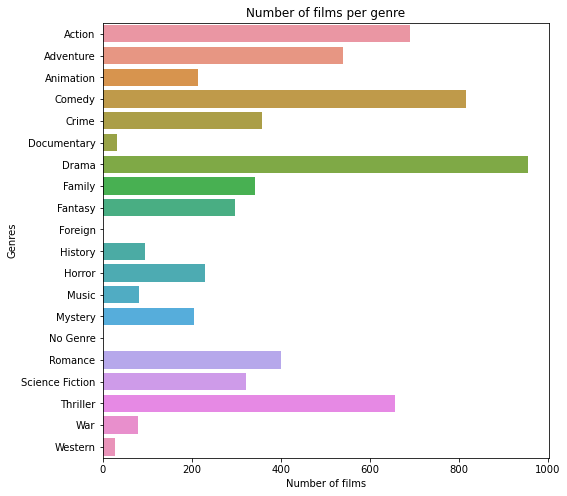

In [88]:
# Plotting the new dummy variables as a bar chart to see what the distribution looks like

count = Genre_dummies.apply(pd.value_counts)
x = list(Genre_dummies.columns)
y = count.iloc[1]
sns.barplot(y, x, orient='h')
plt.title("Number of films per genre")
plt.ylabel('Genres')
plt.xlabel('Number of films');

It seems that drama is the most popular genre, with comedy, action, and thriller also being overrepresented.  Both the foreign and no genre categories have a value of one.  It seems that I've found an inelegant way to see which categories appear the most frequently.  Next I need to represent how these genres relate to my target variable. 

In [89]:
# in order to connect the new dummy variables to revenue I need to join the revenue column to Genre_dummies

Genre_rev = Genre_dummies.join(boxofc_num['revenue'])
Genre_rev.head(3)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,Horror,Music,Mystery,No Genre,Romance,Science Fiction,Thriller,War,Western,revenue
0,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"48,982,041.00"
2,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


In [90]:
def cat_summary(df):
    """This function will take a data frame of dummy variables that has had the revenue column joined to it and return a 
    bar graph that displays the same data frame sorted by median revenue as well as a pandas series with revenue information"""
    median = {}
    for x in df:
        median[x] = df['revenue'][df[x] == 1].median()
    medians = pd.Series(median)
    medians = medians.sort_values(ascending=False)
    sns.barplot(list(medians.values), list(medians.index), orient='h').set(yticklabels=[])
    plt.xlabel('Median Revenue')
    return medians

Animation         170,857,334.50
Family            150,975,050.50
Adventure         149,878,437.00
Fantasy           140,716,486.50
Science Fiction   118,000,000.00
Action            117,487,473.00
Comedy            106,031,284.00
Western            93,798,977.00
War                92,441,274.50
Thriller           90,970,807.00
Music              90,874,570.00
Mystery            87,727,807.00
Romance            85,512,300.00
Crime              84,872,444.00
History            76,806,063.00
Drama              76,669,806.00
Horror             70,355,813.00
Documentary         7,502,105.50
Foreign             2,108,869.50
No Genre              989,465.00
revenue                      nan
dtype: float64

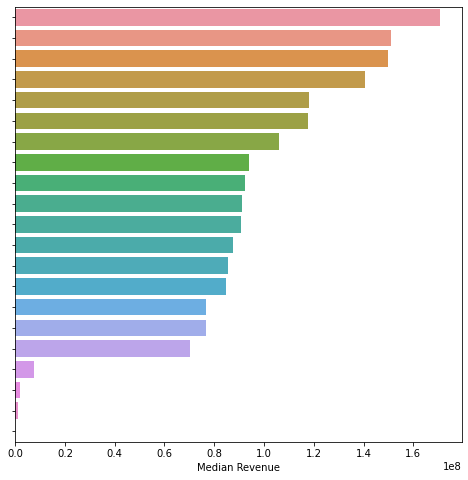

In [91]:
cat_summary(Genre_rev)

### Observations on Genre:

I hypothesized that Drama would be the highest grossing genre, howevver it seems that the median revenue for Drama films is actually on the lower end.  Rather surprisingly the highest median revenue by film is for Animation films.  

It is interesting to note that the distribution of median revenue among the genres is expondntially distributed and that there is a steep drop-off for documentary and foreign films.

### Working with the 'Collection' category:

Now I'm going to apply the cleaning process I just figured out using the genres column to my other categorical variables, beginning with the 'belongs_to_collection' column.  I also hypothesize here that being part of a larger collection has a minimal impact on revenue. 

In [92]:
boxofc_cat['belongs_to_collection'] = boxofc_cat['belongs_to_collection'].fillna('No Collection')
Collection_dummies = pd.get_dummies(boxofc_cat['belongs_to_collection'].apply(pd.Series).stack()).sum(level=0)
Collection_rev = Collection_dummies.join(boxofc_num['revenue'])
Collection_rev.head(3)

,... Has Fallen Collection,101 Dalmatians (Animated) Collection,101 Dalmatians (Live-Action) Collection,28 Days/Weeks Later Collection,30 Days of Night Collection,300 Collection,48 Hrs. Collection,8MM Collection,A Haunted House Collection,A Nightmare on Elm Street Collection,...,Wolf Warriors Collection,Wonder Woman Collection,Wong Kar-Wai's Informal Collection,Would I Lie to You? Collection,Wreck-It Ralph Collection,X-Men Collection,Zoolander Collection,Zorro Collection,xXx Collection,revenue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


,Count
James Bond Collection,18
Pokémon Collection,9
Rocky Collection,7
Star Trek: The Original Series Collection,6
Saw Collection,6
...,...
Road Trip Collection,1
Robert Langdon Collection,1
Dolphin Tale Collection,1
Rocky Horror Collection,1


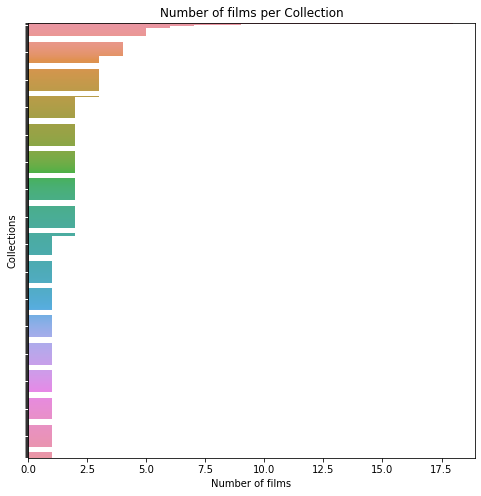

In [93]:
count = Collection_dummies.apply(pd.value_counts)
x = list(Collection_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
count = count.drop(labels='No Collection', axis=0)                           
sns.barplot(x='Count', y=list(count.index), data=count, orient='h').set(yticklabels=[])
plt.title("Number of films per Collection")
plt.ylabel('Collections')
plt.xlabel('Number of films');
count

Median Revenue for films with no collection:  82781822.5


The Avengers Collection                  1,405,413,868.00
The Fast and the Furious Collection      1,377,405,338.00
Frozen Collection                        1,276,480,335.00
Iron Man Collection                      1,215,439,994.00
Pirates of the Caribbean Collection      1,045,713,802.00
                                               ...       
Dracula (Hammer Series)                        547,443.00
Planet of the Apes Original Collection         520,739.00
Death Race Original Collection                 270,337.00
Qatsi Collection                               155,640.00
revenue                                               nan
Length: 421, dtype: float64

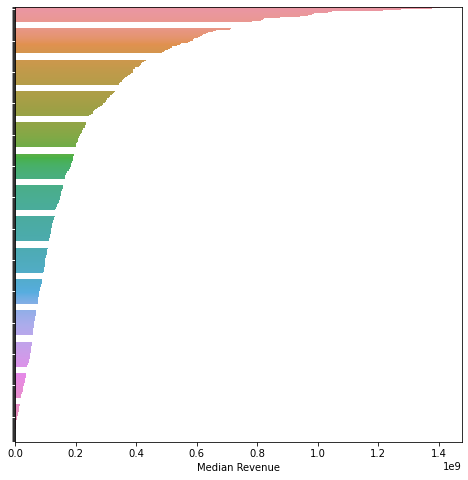

In [94]:
print('Median Revenue for films with no collection: ', Collection_rev['revenue'][Collection_rev['No Collection'] == 1].median())
cat_summary(Collection_rev)

### Observations on Collections:

It's notable that the median revenue for films without a larger collection is so small(0.08e9 USD) that it barely registers on the bar graph.  Suddenly the Hollywood penchant for remakes and sequels makes much more sense! 

It seems that my hypothesis that belonging to a larger collection **does** have a significant impact on revenue. 

### Examining the Production Companies column:


In [95]:
boxofc_cat['production_companies'] = boxofc_cat['production_companies'].fillna("['No Company']")
boxofc_cat.production_companies = boxofc_cat.production_companies.apply(lambda x: ast.literal_eval(x))
Company_dummies = pd.get_dummies(boxofc_cat['production_companies'].apply(pd.Series).stack()).sum(level=0)
Company_rev = Company_dummies.join(boxofc_num['revenue'])
Company_rev.head(3)

,100 Bares,10th Hole Productions,11:11 Mediaworks,120 Films,1492 Pictures,16 Block Productions,1600 Limited Partnership,1984 Private Defense Contractors,2 Entertain,20th Century Fox Russia,...,d-rights,double A Films,icon,thinkfilm,uFilm,uFund,venezia 64,warner bross Turkey,Check Entertainment,revenue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


,Count
Universal Pictures,242
Warner Bros.,224
Twentieth Century Fox Film Corporation,186
Paramount Pictures,179
Columbia Pictures,120
...,...
Horsefly Productions,1
HorsePower Entertainment,1
HorrorFlix,1
Horizon Pictures,1


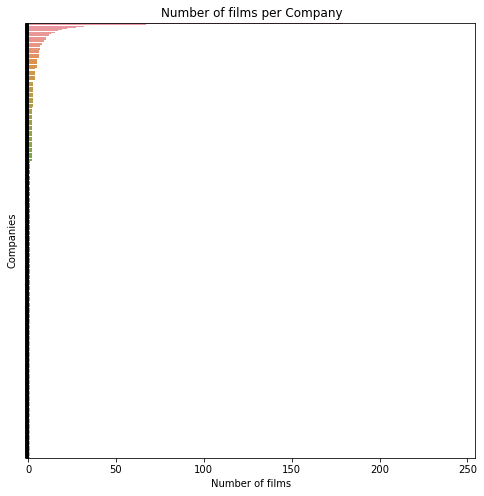

In [96]:
count = Company_dummies.apply(pd.value_counts)
x = list(Company_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=count, orient='h').set(yticklabels=[])
plt.title("Number of films per Company")
plt.ylabel('Companies')
plt.xlabel('Number of films');
count

Colorado Office of Film, Television & Media   1,516,045,911.00
Abu Dhabi Film Commission                     1,516,045,911.00
Deluxe Digital Studios                        1,153,304,495.00
Vita-Ray Dutch Productions (III)              1,153,304,495.00
Ian Bryce Productions                         1,104,039,076.00
                                                    ...       
Catherine Dussart Productions (CDP)                  76,933.00
Bophana Production                                   76,933.00
Angoa-Agicoa                                         76,933.00
Playfilm Productions                                 38,872.00
revenue                                                    nan
Length: 2689, dtype: float64

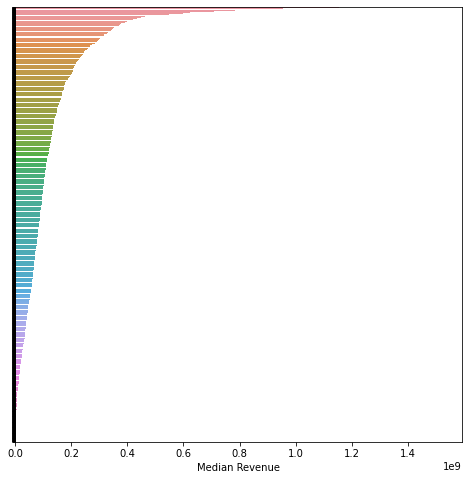

In [97]:
cat_summary(Company_rev)

### Observations on Production Countries:

It's interesting to note that the distribution of films produced by company is heavily skewed towards 'big players' in the film space.  During the next step towards modelling revenue by film I'll need to bin all productions companies with only a single film into a new category titled 'minor companies'.

### Examining Production Countries column

In [98]:
boxofc_cat['production_countries'] = boxofc_cat['production_countries'].fillna("['No Country']")
boxofc_cat.production_countries = boxofc_cat.production_countries.apply(lambda x: ast.literal_eval(x))
Country_dummies = pd.get_dummies(boxofc_cat['production_countries'].apply(pd.Series).stack()).sum(level=0)
Country_rev = Country_dummies.join(boxofc_num['revenue'])
Country_rev.head(3)

,Argentina,Australia,Austria,Bahamas,Belgium,Bolivia,Botswana,Brazil,Bulgaria,Cambodia,...,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States of America,Uruguay,Venezuela,revenue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


,Count
United States of America,2038
United Kingdom,304
France,146
Germany,146
Canada,105
...,...
Colombia,1
Botswana,1
Bolivia,1
Bahamas,1


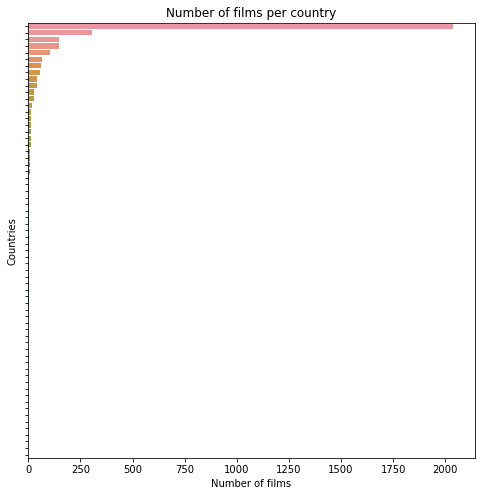

In [99]:
count = Country_dummies.apply(pd.value_counts)
x = list(Country_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=count, orient='h').set(yticklabels=[])
plt.title("Number of films per country")
plt.ylabel('Countries')
plt.xlabel('Number of films');
count

Slovenia      419,651,413.00
Malta         240,942,515.00
Pakistan      215,663,859.00
Taiwan        213,525,736.00
Philippines   203,277,636.00
                   ...      
Norway          1,353,468.00
Bolivia         1,217,307.00
Finland           332,710.00
Israel            332,710.00
revenue                  nan
Length: 67, dtype: float64

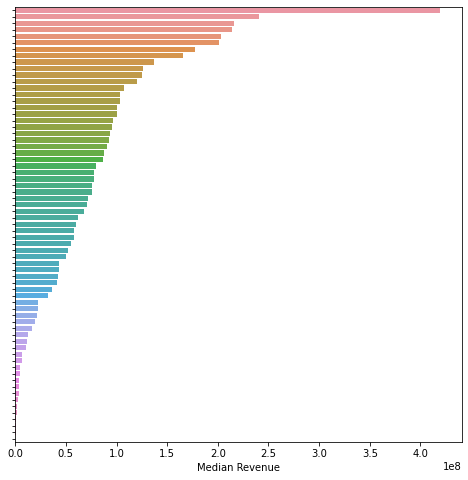

In [100]:
cat_summary(Country_rev)

### Observations on Production Countries:

The distribution of films produced among countries is *extremely* skewed towards the USA, which is expected.  However what is notable is that this skew does not carry over to the median revenue of films produced in each country, which seems to have little correlation to the number of films produced in that country.

### Examining the Keywords Column

In [101]:
boxofc_cat['Keywords'] = boxofc_cat['Keywords'].fillna("['No Keywords']")
boxofc_cat.Keywords = boxofc_cat.Keywords.apply(lambda x: ast.literal_eval(x))
Keywords_dummies = pd.get_dummies(boxofc_cat['Keywords'].apply(pd.Series).stack()).sum(level=0)
Keywords_rev = Keywords_dummies.join(boxofc_num['revenue'])
Keywords_rev.head(3)

,15th century,16th century,17th century,18th century,1910s,1920s,1930s,1940s,1950s,1960s,...,,north carolinam,nosferatu,strange noise,ÁªùÂú∞Â•∂Èú∏,ÂçßÂ∫ïËÇ•Â¶à,Ë∂ÖÁ∫ßÂ¶àÂ¶à,ŒìŒ∑,√òverste hylde,revenue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


,Count
duringcreditsstinger,188
based on novel,146
aftercreditsstinger,110
woman director,98
murder,96
...,...
law student,1
law firm,1
law enforcement,1
botswana,1


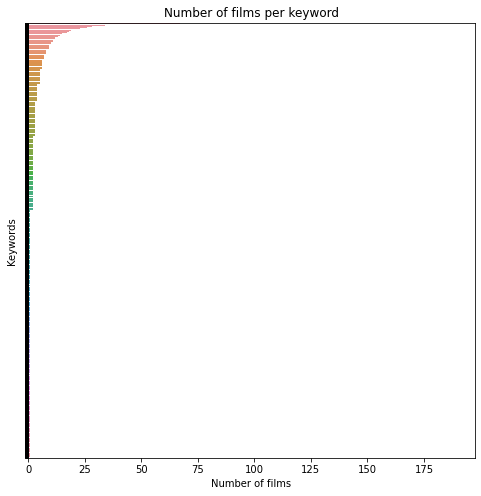

In [102]:
count = Keywords_dummies.apply(pd.value_counts)
x = list(Keywords_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=count, orient='h').set(yticklabels=[])
plt.title("Number of films per keyword")
plt.ylabel('Keywords')
plt.xlabel('Number of films');
count

race               1,516,045,911.00
muscle car         1,516,045,911.00
mountain climber   1,276,480,335.00
snowman            1,276,480,335.00
mysterious woman   1,238,764,765.00
                         ...       
railway station           38,872.00
tantrum                   38,872.00
struggle                  38,872.00
b horror                   5,806.00
revenue                         nan
Length: 7135, dtype: float64

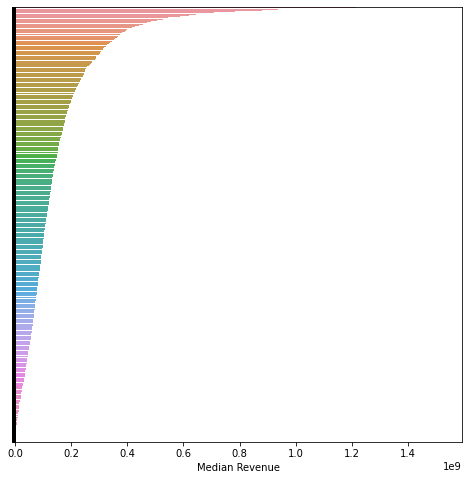

In [103]:
cat_summary(Keywords_rev)

### Observations on Keywords:

The keywords category seems to have a similar relationship between the number of films produced by keyword and revenue by keyword.  

The three keywords that appear in over 100 films (duringcreditsstinger, based on novel, aftercreditsstinger) are not in the top keywords for revenue(race, muscle car, mountain climber).  However the three most common keywords **do** suggest that they ar for films that belong to a larger film collection which should indicate a higher revenue in general.  

This runs counter to intuition since the three most common keywords should be indicators of another feature that seems to indicate high revenue (belonging to a larger collection). I suspect that this may be a result of using the median as opposed to the mean revenue per category for my analysis, and will later check this in a separate notebook to see if these relationships are preserved regardless of the descriptive statistic used.   

### Examining the Cast column:

Commenting out code blocks for Cast & Crew because my machine doesn't have the RAM to handle the processing for now.

In [104]:
#boxofc_cat['cast'] = boxofc_cat['cast'].fillna("['No Cast']")
#boxofc_cat.cast = boxofc_cat.cast.apply(lambda x: ast.literal_eval(x))
#Cast_dummies = pd.get_dummies(boxofc_cat['cast'].apply(pd.Series).stack()).sum(level=0)
#Cast_rev = Cast_dummies.join(boxofc_num['revenue'])
#Cast_rev.head(3)

# Good opportunity to revisit how to accomplish this - potentially bin actors/actresses

In [105]:
#count = Cast_dummies.apply(pd.value_counts)
#x = list(Cast_dummies.columns)
#y = count.iloc[1]
#sns.barplot(y, x, orient='h')
#plt.title("Number of films per cast member")
#plt.ylabel('Cast members')
#plt.xlabel('Number of films');

In [106]:
#cat_summary(Cast_rev)

### Examining the Crew Column:

In [107]:
"""boxofc_cat['crew'] = boxofc_cat['crew'].fillna("['No Keywords']")
boxofc_cat.crew = boxofc_cat.crew.apply(lambda x: ast.literal_eval(x))
Crew_dummies = pd.get_dummies(boxofc_cat['crew'].apply(pd.Series).stack()).sum(level=0)
Crew_rev = Crew_dummies.join(boxofc_num['revenue'])
Crew_rev.head(3)"""

'boxofc_cat[\'crew\'] = boxofc_cat[\'crew\'].fillna("[\'No Keywords\']")\nboxofc_cat.crew = boxofc_cat.crew.apply(lambda x: ast.literal_eval(x))\nCrew_dummies = pd.get_dummies(boxofc_cat[\'crew\'].apply(pd.Series).stack()).sum(level=0)\nCrew_rev = Crew_dummies.join(boxofc_num[\'revenue\'])\nCrew_rev.head(3)'

In [108]:
"""count = Crew_dummies.apply(pd.value_counts)
x = list(Crew_dummies.columns)
y = count.iloc[1]
sns.barplot(y, x, orient='h')
plt.title("Number of films per crew member")
plt.ylabel('Crew members')
plt.xlabel('Number of films');"""

'count = Crew_dummies.apply(pd.value_counts)\nx = list(Crew_dummies.columns)\ny = count.iloc[1]\nsns.barplot(y, x, orient=\'h\')\nplt.title("Number of films per crew member")\nplt.ylabel(\'Crew members\')\nplt.xlabel(\'Number of films\');'

In [109]:
#cat_summary(Crew_rev)

### Examining Spoken_lang Column:

In [110]:
boxofc_cat['spoken_languages'] = boxofc_cat['spoken_languages'].fillna("['No Language']")
boxofc_cat.spoken_languages = boxofc_cat.spoken_languages.apply(lambda x: ast.literal_eval(x))
Spoken_dummies = pd.get_dummies(boxofc_cat['spoken_languages'].apply(pd.Series).stack()).sum(level=0)
Spoken_rev = Spoken_dummies.join(boxofc_num['revenue'])
Spoken_rev.head(3)

,,Afrikaans,Bahasa indonesia,Bahasa melayu,Bamanankan,Català,Cymraeg,Dansk,Deutsch,Eesti,...,বাংলা,ਪੰਜਾਬੀ,தமிழ்,తెలుగు,ภาษาไทย,广州话 / 廣州話,日本語,普通话,한국어/조선말,revenue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


            Count
English  2,180.00
Français   221.00
Español    174.00
Deutsch    133.00
Pусский    101.00
               Count
Wolof           1.00
Català          1.00
Bamanankan      1.00
Bahasa melayu   1.00
isiZulu         1.00


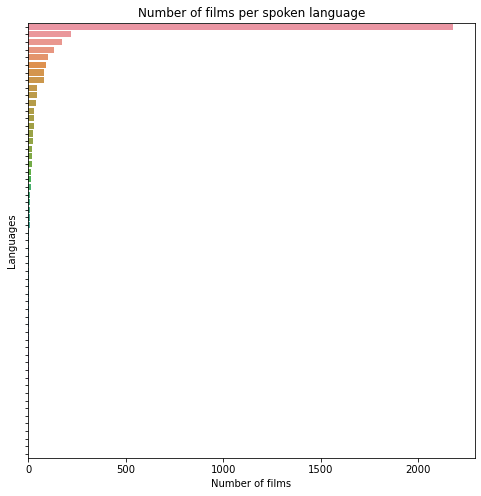

In [111]:
count = Spoken_dummies.apply(pd.value_counts)
x = list(Spoken_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=count, orient='h').set(yticklabels=[])
plt.title("Number of films per spoken language")
plt.ylabel('Languages')
plt.xlabel('Number of films');
print(count.head(5))
print(count.tail(5))

Íslenska           241,995,151.00
isiZulu            210,819,611.00
Somali             195,890,731.00
తెలుగు             188,614,156.50
ภาษาไทย            173,128,787.00
Română             155,010,032.00
Afrikaans          135,409,805.50
български език     133,271,454.00
suomi              133,000,000.00
普通话                122,493,855.00
اردو               120,388,865.00
العربية            119,394,754.50
Italiano           116,785,898.50
ελληνικά           113,019,290.00
Latin              112,073,421.50
Français           106,371,651.00
Nederlands         104,942,071.00
Tiếng Việt         102,472,539.50
svenska            102,204,597.50
English            100,031,063.50
Srpski              99,965,792.00
Slovenčina          98,929,560.50
עִבְרִית            98,604,611.00
Kiswahili           97,837,138.00
Cymraeg             97,143,987.00
Український         96,753,696.00
Hrvatski            95,714,875.00
Pусский             95,226,116.00
فارسی               93,974,620.00
Español       

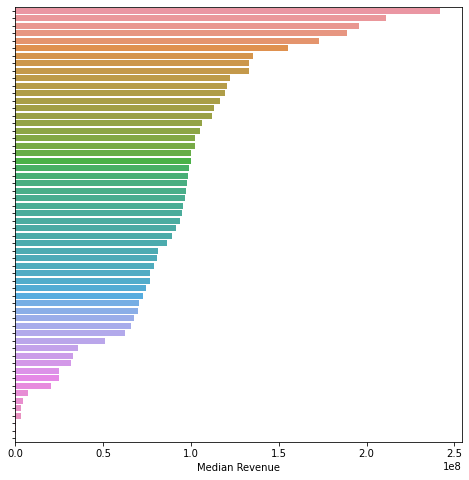

In [112]:
cat_summary(Spoken_rev)

### Observations on Spoken language:

Similar to the production country category it seems that the number of films produced are heavily skewed towards english.  However the revenue seems to be much less skewed than other categories.  It is surprising that the median revenue for english-speaking films is significantly lower than many other films given the number of films that are produced in that language. 

### Examining Original_language:

In [113]:
boxofc_cat['original_language'] = boxofc_cat['original_language'].fillna("['No Language']")
#boxofc_cat.original_language = boxofc_cat.original_language.apply(lambda x: ast.literal_eval(x))
Language_dummies = pd.get_dummies(boxofc_cat['original_language'].apply(pd.Series).stack()).sum(level=0)
Language_rev = Language_dummies.join(boxofc_num['revenue'])
Language_rev.head(3)

,bn,cn,cs,da,de,el,en,es,fa,fr,...,no,pl,pt,ru,sv,ta,te,tr,zh,revenue
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"48,982,041.00"
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


,Count
en,2142
ja,37
fr,31
zh,28
hi,15
cn,13
ko,12
es,9
de,8
da,6


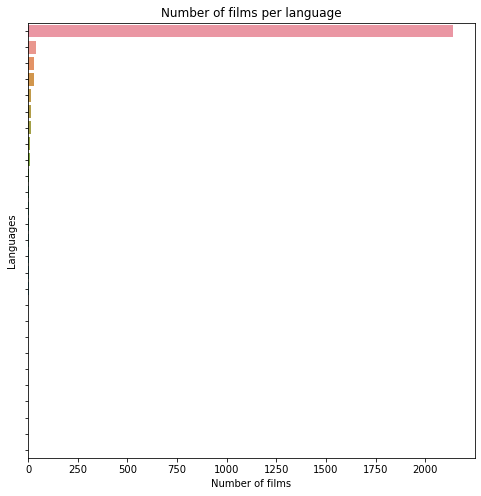

In [114]:
count = Language_dummies.apply(pd.value_counts)
x = list(Language_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=count, orient='h').set(yticklabels=[])
plt.title("Number of films per language")
plt.ylabel('Languages')
plt.xlabel('Number of films');
count

te        188,614,156.50
zh        110,077,409.50
en        101,148,082.50
ko         78,101,671.50
ja         50,673,078.00
pt         47,543,488.00
fr         44,315,648.00
sv         41,548,556.00
it         41,323,171.00
ru         41,122,630.50
es         36,353,750.00
cs         20,867,919.00
hi         18,672,790.00
pl         15,298,355.00
cn         13,834,044.00
de         12,301,352.00
da         10,867,582.50
ml          8,957,248.00
hu          6,659,121.00
nl          5,990,754.00
tr          4,915,624.00
bn          3,433,503.00
ta          2,522,840.00
el          2,105,303.00
no          1,984,662.00
fa          1,628,579.00
id            722,274.00
revenue              nan
dtype: float64

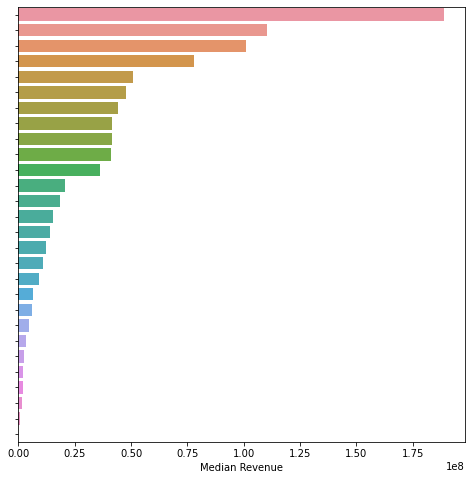

In [115]:
cat_summary(Language_rev)

### Observations on Original Language:

It seems that the distribution for original language is as heavily skewed towards english as the other language category, while the median revenue is highest for the Tegulu language (ISO abbreviation te) which is spoken in India. 

This bar graph also has the smalles scale for median revenue among any category (1.75e8 USD), indicating that this category is not a good predictor for high revenue films - the target for this model. 

I will drop this category from the larger dataset.

## Working with datetime objects

I have a column that includes the release date - I need to break this up into year & month columns that will allow me to further create dummy variables using the above methods and check for annual or monthly trends.

In [116]:
boxofc_cat['release_date'] = pd.to_datetime(boxofc_cat['release_date'])
boxofc_cat['year'] = boxofc_cat['release_date'].dt.year
boxofc_cat['month'] = boxofc_cat['release_date'].dt.month

In [117]:
boxofc_cat['year'] = boxofc_cat['year'].fillna('No Year')
boxofc_cat.year[boxofc_cat.year > 2020] = 'No Year'  # Removed all years in the future since clearly that's not correct
Annual_dummies = pd.get_dummies(boxofc_cat['year'].apply(pd.Series).stack()).sum(level=0)
Annual_rev = Annual_dummies.join(boxofc_num['revenue'])
Annual_rev.head(3)

,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,...,2010,2011,2012,2013,2014,2015,2016,2017,No Year,revenue
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"3,418,605.00"


,Count
2013,124
2016,113
2015,113
2014,107
2012,105
2011,103
No Year,95
2004,89
2006,87
2007,85


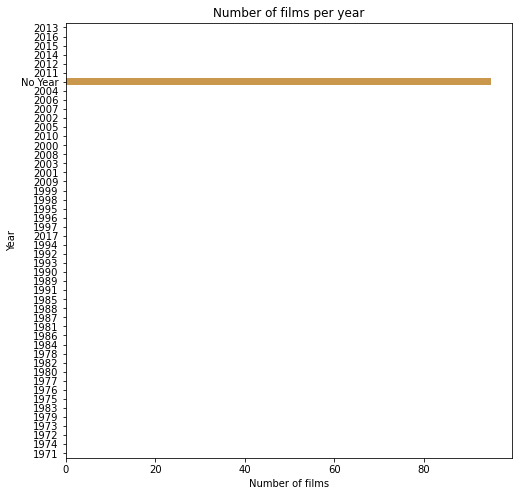

In [131]:
count = Annual_dummies.apply(pd.value_counts)
x = list(Annual_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=Year)
plt.title("Number of films per year")
plt.ylabel('Year')
plt.xlabel('Number of films');
count

2017      225,874,228.00
2016      150,680,864.00
1979      139,000,000.00
1990      136,766,062.00
2014      127,994,610.00
1983      127,092,670.00
1997      125,247,948.00
1992      120,000,000.00
1991      119,418,501.00
1998      117,836,456.00
1993      117,727,083.00
2008      108,979,549.00
1994      108,431,355.00
2015      107,588,225.00
1996      102,720,989.50
1995      102,662,041.50
2006      100,523,181.00
2005       97,404,330.50
2011       97,143,987.00
2009       96,234,285.50
2004       96,105,964.00
1999       95,253,439.50
2013       93,870,934.50
2000       93,598,280.00
2003       93,067,431.00
2007       91,354,215.00
1989       90,000,098.00
2010       89,895,930.00
2001       84,772,742.00
1988       84,460,846.00
2012       84,384,002.00
1982       83,843,672.00
1984       80,000,000.00
2002       78,062,082.50
1986       77,200,000.00
1973       67,338,468.50
1987       67,002,412.50
1974       55,200,000.00
1980       53,000,000.00
1985       48,679,151.50


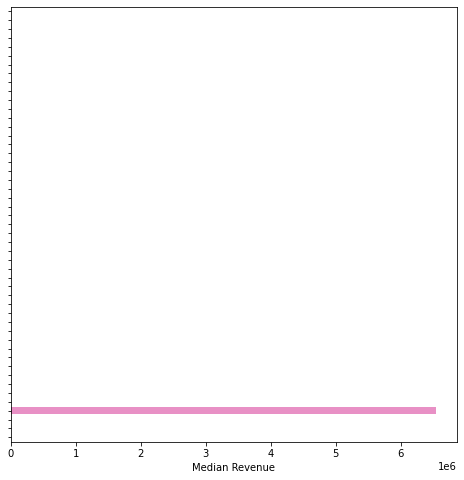

In [128]:
cat_summary(Annual_rev)

In [129]:
boxofc_cat['month'] = boxofc_cat['month'].fillna('No Year')
Monthly_dummies = pd.get_dummies(boxofc_cat['month'].apply(pd.Series).stack()).sum(level=0)
Monthly_rev = Monthly_dummies.join(boxofc_num['revenue'])
Monthly_rev.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,revenue
0,0,0,0,0,0,0,0,1,0,0,0,0,"134,734,481.00"
1,0,0,0,0,0,0,0,0,0,1,0,0,"48,982,041.00"
2,0,0,0,0,0,0,0,1,0,0,0,0,"3,418,605.00"


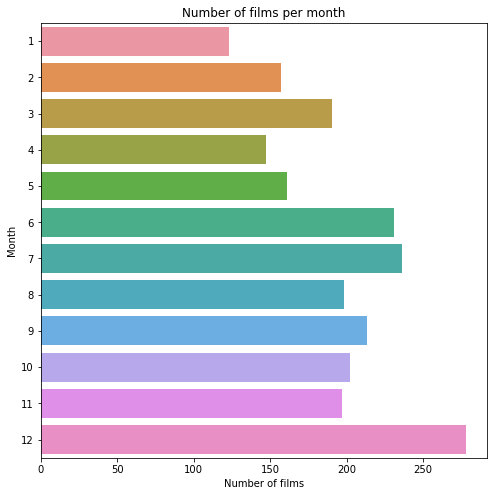

In [130]:
count = Monthly_dummies.apply(pd.value_counts)
x = list(Monthly_dummies.columns)
y = count.iloc[1]
count = pd.DataFrame({'Count' : y}).sort_values(by='Count', ascending=False)
sns.barplot(x='Count', y=list(count.index), data=count, orient='h')
plt.title("Number of films per month")
plt.ylabel('Month')
plt.xlabel('Number of films');

In [ ]:
cat_summary(Monthly_rev)

### Observations on Datetime objects:


It seems that there is somewhat of a trend towards releasing more films as time goes on, and that there is a general trend towards higher revenue as time goes on as well.  This indicates that the 'year' category could be a good predictor for revenue.  Similarly the number and median revenue of films is spread relateively evenly across the months, I'm not certain that it will be a strong predictor of revenue but using lasso regression should indicate it's usefulness. 

## Combinding dummy variables back into a single data frame

In [ ]:
boxofc_cat.columns

In [ ]:
# Drop all columns that have been on-hot encoded
categorical = boxofc_cat.drop(labels=['belongs_to_collection', 'genres', 'original_language','production_companies',
                                      'production_countries', 'release_date', 'spoken_languages', 'Keywords', 'cast', 
                                      'crew', 'collectionbool', 'year', 'month'], axis=1)
frames = [Genre_dummies, Collection_dummies, Company_dummies, Country_dummies, Spoken_dummies, Keywords_dummies, 
          categorical, boxofc_num, Annual_dummies, Monthly_dummies]
categorical.head(3)

In [ ]:
BoxOffice = pd.concat(frames, keys=frames, axis=1)
BoxOffice.head(3)

In [ ]:
for i in frames:
    print(i.shape)